In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV # using Randomized Search instead of Grid Search 
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix



import warnings
warnings.filterwarnings('ignore')

In [2]:
#getting dataset from UCI repository
heart_disease = pd.read_csv(r'C:\Users\hp\Downloads\heart (1).csv')
print(heart_disease['target'].value_counts())

target
1    165
0    138
Name: count, dtype: int64


In [3]:
heart_disease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


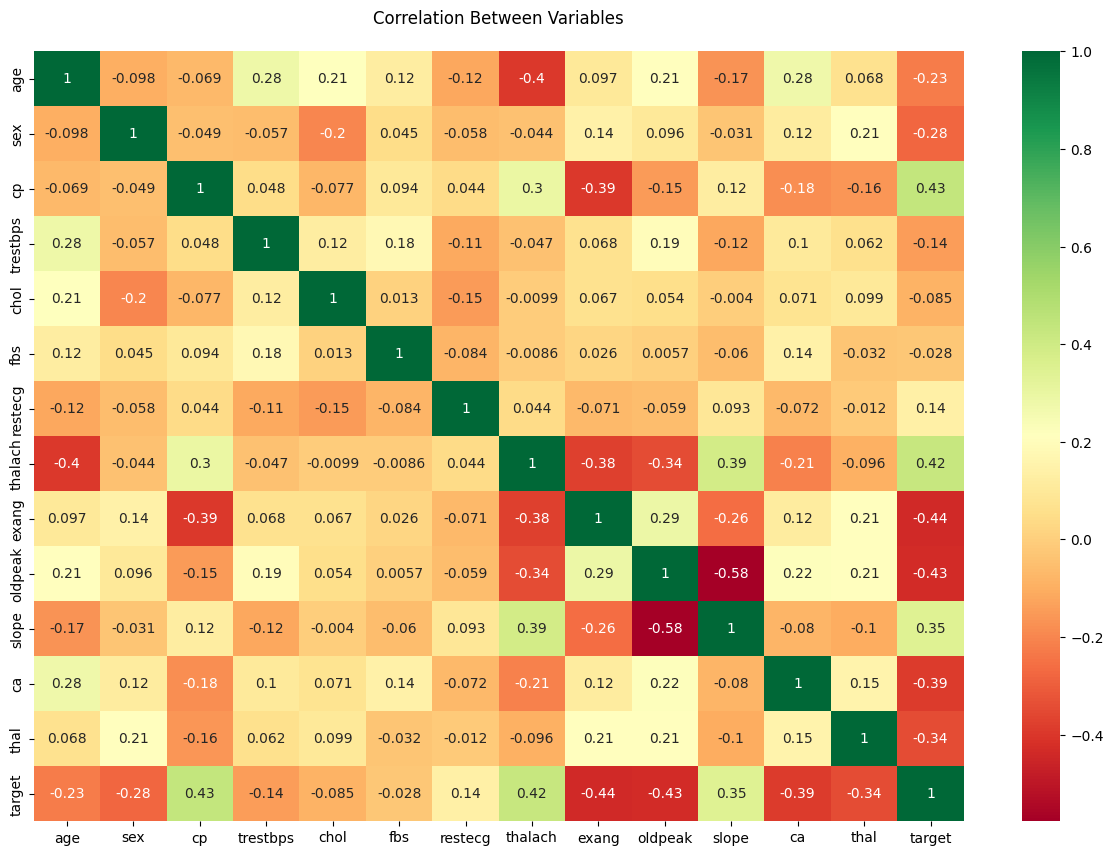

In [4]:
#plotting correlation
plt.figure(figsize=(15,10))
sns.heatmap(heart_disease.corr(), annot=True, cmap="RdYlGn")
plt.title('Correlation Between Variables', pad = 20)
plt.show()

##### Thalach, cp, exang, oldpeak, slope, ca, thal are features that are correlated with the target variable

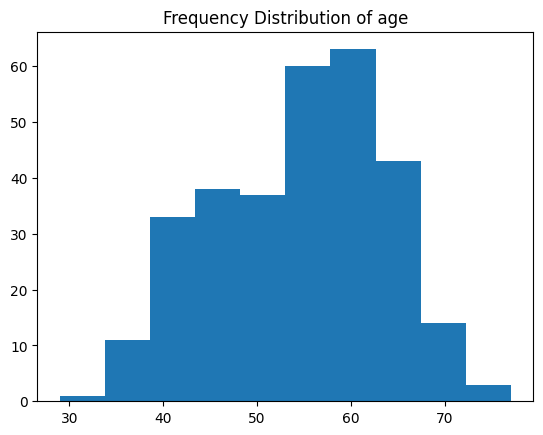

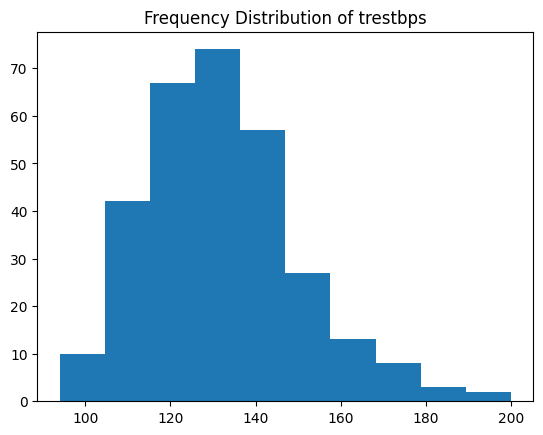

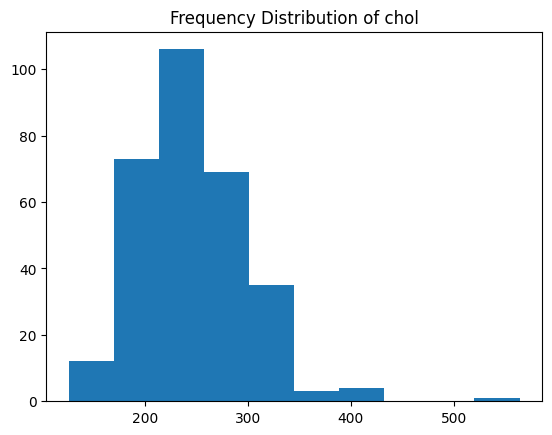

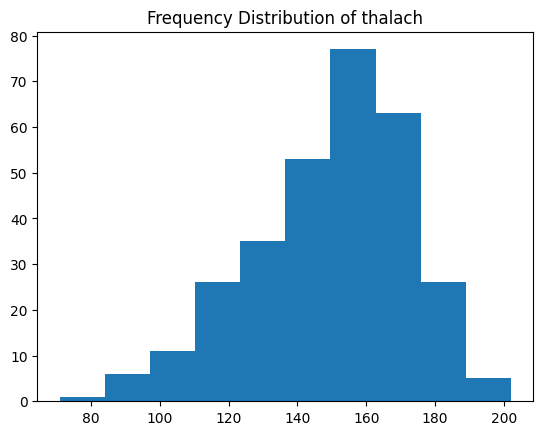

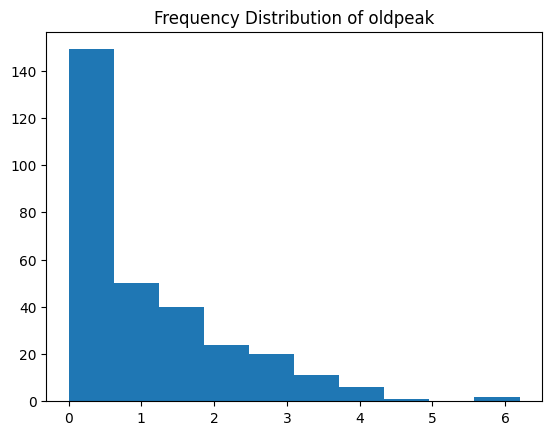

In [5]:
columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
for col in columns:
    plt.hist(heart_disease[col])
    plt.title(f'Frequency Distribution of {col}')
    plt.show()
# For some models that uses distance and to avoid assigning more weight to a particular set of values thereby introducing biaseness, z score normalization is used. 

In [6]:
# Accessing values that I presumed not to need normalization
filtered_df = heart_disease[heart_disease.columns.difference(columns)]
#. difference and .intersection method that comes with the .columns attribute
#. difference - not matching
# intersect - matching

for col in filtered_df.columns:
    print(filtered_df[col].value_counts())

# These values does not need scaling

ca
0    175
1     65
2     38
3     20
4      5
Name: count, dtype: int64
cp
0    143
2     87
1     50
3     23
Name: count, dtype: int64
exang
0    204
1     99
Name: count, dtype: int64
fbs
0    258
1     45
Name: count, dtype: int64
restecg
1    152
0    147
2      4
Name: count, dtype: int64
sex
1    207
0     96
Name: count, dtype: int64
slope
2    142
1    140
0     21
Name: count, dtype: int64
target
1    165
0    138
Name: count, dtype: int64
thal
2    166
3    117
1     18
0      2
Name: count, dtype: int64


In [7]:
# Scaling the values
StandardScaler = StandardScaler() # Standard scaler() uses z-score normalization
# copy dataset 
dataset = heart_disease.copy()
dataset[columns] = StandardScaler.fit_transform(dataset[columns])

In [8]:
dataset[columns]

,age,trestbps,chol,thalach,oldpeak
0,0.952197,0.763956,-0.256334,0.015443,1.087338
1,-1.915313,-0.092738,0.072199,1.633471,2.122573
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705
4,0.290464,-0.663867,2.082050,0.583939,-0.379244
...,...,...,...,...,...
298,0.290464,0.478391,-0.101730,-1.165281,-0.724323
299,-1.033002,-1.234996,0.342756,-0.771706,0.138373
300,1.503641,0.706843,-1.029353,-0.378132,2.036303
301,0.290464,-0.092738,-2.227533,-1.515125,0.138373


In [9]:
# separating into independent features and dependent features (target variable)
X = dataset.drop('target', axis = 1)
y = dataset['target']


#### Training Model

Fitting 5 folds for each of 20 candidates, totalling 100 fits
===== fold 1 ===== 
0.8125435540069686
===== fold 2 ===== 
0.7839721254355401
===== fold 3 ===== 
0.6619318181818181
===== fold 4 ===== 
0.8386752136752137
Mean Accuracy: 0.7742806778248852
Train Set Accuracy: 0.8879551820728291
[[29  7]
 [ 5 34]]


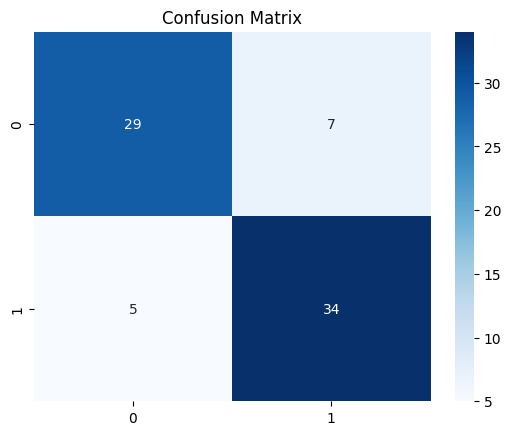

In [10]:
# Training xgboost
param_grid = {   # defining parameters to find best parameters
    'n_estimators': [50, 100, 200],
    'learning_rate':[0.01, 0.1, 0.2],
    'max_depth':[3, 5, 7],
    'gamma':[0, 0.1, 0.2],
    'scale_pos_weight':[1,2,5]}  


random_search = RandomizedSearchCV(    # using randomizedsearchCV to find the best parameters for the XGB model 
    estimator= XGBClassifier(), param_distributions=param_grid, n_iter=20, cv=5, random_state=42,
    verbose=2, n_jobs=-1  # Utilize all CPU cores
)

random_search.fit(X, y) # fitting dataset 
best_params = random_search.best_params_ # getting the best parameters
kfold = KFold(n_splits= 4, shuffle=True, random_state=42) # creating an instance of kfold cross validation

model = XGBClassifier(**best_params, objective='binary:logistic', random_state = 42) # creating an instance of xgboost model

count = 0 # initialize count to count number of folds 
# using for loop, split into test and train set for the dependent and independent variable, make predictions and print accuracy 
kfold_score = []
for train_index, test_index in kfold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 

    model.fit(X_train, y_train)
    X_pred = model.predict(X_train) # performance on seen data: predicting probability
    train_auc = roc_auc_score(y_train, X_pred)

    y_pred = model.predict(X_test) # performance on unseen data: predicting the probability
    auc = roc_auc_score(y_test, y_pred)
    count += 1
    print(f'===== fold {count} ===== \n{auc}') # using auc evaluation metrics
    kfold_score.append(auc)
print(f"Mean Accuracy: {np.mean(kfold_score)}")
print(f'Train Set Accuracy: {train_auc}')

# compute confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# visualize confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()